In [1]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import folium
import contextily as cx
import numpy as np

%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

C:\Users\maaik\miniconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


'1.3.1.post0'

---
### Calulating the Criticality Using the Weighted Cost Function

Start with a graph that contains the populations and a gdf of cities with the populations and osmids.

In [70]:
finalgraph = ox.load_graphml('./results/CutSegougraphLEEG1007231715.graphml')
Segoupopulations = pd.read_csv('./data/PopulationsSegou.csv',  encoding= 'unicode_escape', sep= ';')

In [71]:
Segoupopulations
#Malipopulations = Malipopulations.drop(columns=['Unnamed: 0', 'highway', 'contraction', 'admin_name', 'closest_stop_geom'])

,Number,city,1987,1998,2014,Region,osmid,Population
0,6.0,Ségou,88 135,90 898,102099.0,Ségou,8493954406,102099
1,8.0,Niono,17 934,40 513,92431.0,Ségou,707378155,92431
2,9.0,Markala,19 508,37 114,63754.0,Ségou,2109314025,63754
3,22.0,San,30 772,26 744,24813.0,Ségou,4431009766,24813
4,NaN,Sokolo,NaN,NaN,NaN,15782,2118621109,15782


In [72]:
gdf_nodespop, gdf_edgespop = ox.graph_to_gdfs(finalgraph)
gdf_nodespop['population'] = gdf_nodespop['population'].astype(float)

In [73]:
nrofcities = len(Segoupopulations)

In [74]:
#Build an empty matrix with all cities on the row and column indexes
weightM = pd.DataFrame(np.zeros([nrofcities, nrofcities]))
weightM.columns = Segoupopulations.city
listcities = list(weightM.columns.values)
weightM['Title_Origin'] = listcities
weightM = weightM.set_index('Title_Origin', drop=True)
traveltimeM = weightM.copy()

In [75]:
#fill the matrix
normalisefactor = 0
for i in range(0, len(weightM)):
    cityosmid1 = Segoupopulations.osmid[i]
    population1 = Segoupopulations.Population[i]
    city1 = Segoupopulations.city[i]
    for j in range (i, len(weightM)):
        cityosmid2 = Segoupopulations.osmid[j]
        population2 = Segoupopulations.Population[j]
        city2 = Segoupopulations.city[j]
        pops = population1 * population2

        if nx.has_path(finalgraph, cityosmid1, cityosmid2):
            #distance between two cities
            distance = nx.shortest_path_length(finalgraph, source=cityosmid1, target=cityosmid2, weight='length', method='dijkstra')/1000
            if distance == 0:
                weightM.at[city1,city2] =0
                traveltimeM.at[city1,city2] =0
            else:
                #Using the normalisefactor to sum all values immediately for the normalisation
                normalisefactor = normalisefactor +  (pops / (distance**2))
                weightM.at[city1,city2] = pops / (distance**2)
                # Matrix of Traveltimes in hours and with the assumption people drive about 70 km / hour
                traveltimeM.at[city1,city2] = distance/70

#normalisation
normalisedweightM = weightM/normalisefactor

In [76]:
undirgdf_nodes, undirgdf_edges = ox.graph_to_gdfs(finalgraph)
undirgdf_edges = undirgdf_edges.reset_index()
nredges = nx.number_of_edges(finalgraph)

In [77]:
graph = finalgraph.copy()

In [78]:
for e in range (0, nredges):
    u = undirgdf_edges.u[e]
    v = undirgdf_edges.v[e]
    q = 0
    Q = finalgraph.copy()
    Q.remove_edge(u, v)

    WijTijM = pd.DataFrame(np.zeros([nrofcities, nrofcities])) #empty matrix with all wij and tij of 1 edge

    for i in range(0, len(traveltimeM)):
        city1 = Segoupopulations.city[i]
        cityosmid1 = Segoupopulations.osmid[i]

        #We only do the combination of all cities, because the graph is undirected this means that it does not matter to check the distance from ij or from ji
        for j in range (i, len(traveltimeM)):
            city2 = Segoupopulations.city[j]
            cityosmid2 = Segoupopulations.osmid[j]
            traveltimeold = traveltimeM.at[city1,city2]
            if nx.has_path(Q, cityosmid1, cityosmid2):
                traveltimenew = (nx.shortest_path_length(Q, source=cityosmid1, target=cityosmid2, weight='length', method='dijkstra')/1000)/70
                timedifference=traveltimenew-traveltimeold
                wij = normalisedweightM.at[city1,city2]
                WijTijM.at[i,j]=wij*timedifference
            else: 
                wij = normalisedweightM.at[city1,city2]
                WijTijM.at[i,j]=wij *2 #time difference is taken as 4 hours
                print('No path between',cityosmid1, 'and', cityosmid2, 'with absence of edge:', u, v)

    #Per edge the sum is taken of the WijTij matrix
    sumWT = WijTijM.sum()
    sumWT = sumWT.sum()
    #check how to format u,v
    nx.set_edge_attributes(graph,{(u,v,q):sumWT}, 'criticality')

No path between 8493954406 and 707378155 with absence of edge: 694176832 2116425539
No path between 8493954406 and 2118621109 with absence of edge: 694176832 2116425539
No path between 707378155 and 2109314025 with absence of edge: 694176832 2116425539
No path between 707378155 and 4431009766 with absence of edge: 694176832 2116425539
No path between 2109314025 and 2118621109 with absence of edge: 694176832 2116425539
No path between 4431009766 and 2118621109 with absence of edge: 694176832 2116425539
No path between 8493954406 and 707378155 with absence of edge: 694176832 2109314028
No path between 8493954406 and 2118621109 with absence of edge: 694176832 2109314028
No path between 707378155 and 2109314025 with absence of edge: 694176832 2109314028
No path between 707378155 and 4431009766 with absence of edge: 694176832 2109314028
No path between 2109314025 and 2118621109 with absence of edge: 694176832 2109314028
No path between 4431009766 and 2118621109 with absence of edge: 6941768

In [79]:
Segoupopulations

,Number,city,1987,1998,2014,Region,osmid,Population
0,6.0,Ségou,88 135,90 898,102099.0,Ségou,8493954406,102099
1,8.0,Niono,17 934,40 513,92431.0,Ségou,707378155,92431
2,9.0,Markala,19 508,37 114,63754.0,Ségou,2109314025,63754
3,22.0,San,30 772,26 744,24813.0,Ségou,4431009766,24813
4,NaN,Sokolo,NaN,NaN,NaN,15782,2118621109,15782


In [80]:
a, b = ox.graph_to_gdfs(graph)

TO DO: the roads that cause a disconnected graph have a very heavy stamp on the map. ofc. How to handle this?

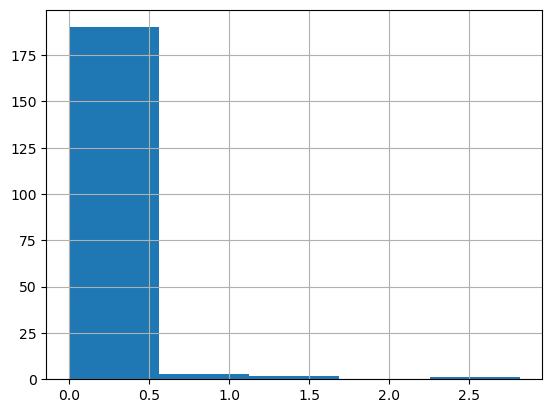

In [81]:
#b.criticality.max()
hist = b.criticality.hist(bins=5)


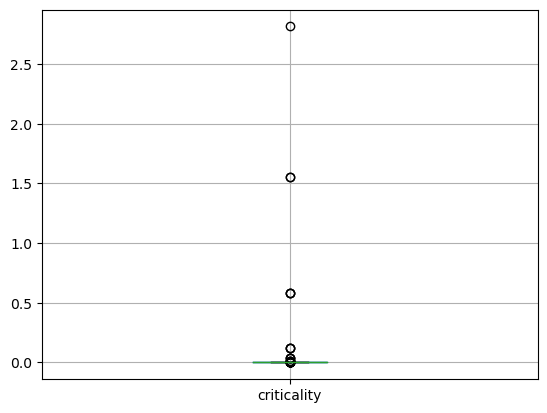

In [82]:
boxplot = b.boxplot(column=['criticality'])  


In [83]:
 q= b['criticality'].nlargest(n=10)
q

u           v           key
8190658621  323195349   0      2.815668
8493954406  937596867   0      1.555351
323195349   2109314025  0      1.552964
694176832   2116425539  0      0.579262
            2109314028  0      0.579262
2116425539  707378155   0      0.579262
2125121385  2118147554  0      0.122018
            707378155   0      0.122018
2118621109  2118147554  0      0.122018
2242614381  7963527159  0      0.038436
Name: criticality, dtype: float64

C:\Users\maaik\miniconda3\envs\ox\lib\site-packages\mapclassify\classifiers.py:1860: UserWarning: Numba not installed. Using slow pure python version.
  warnings.warn(


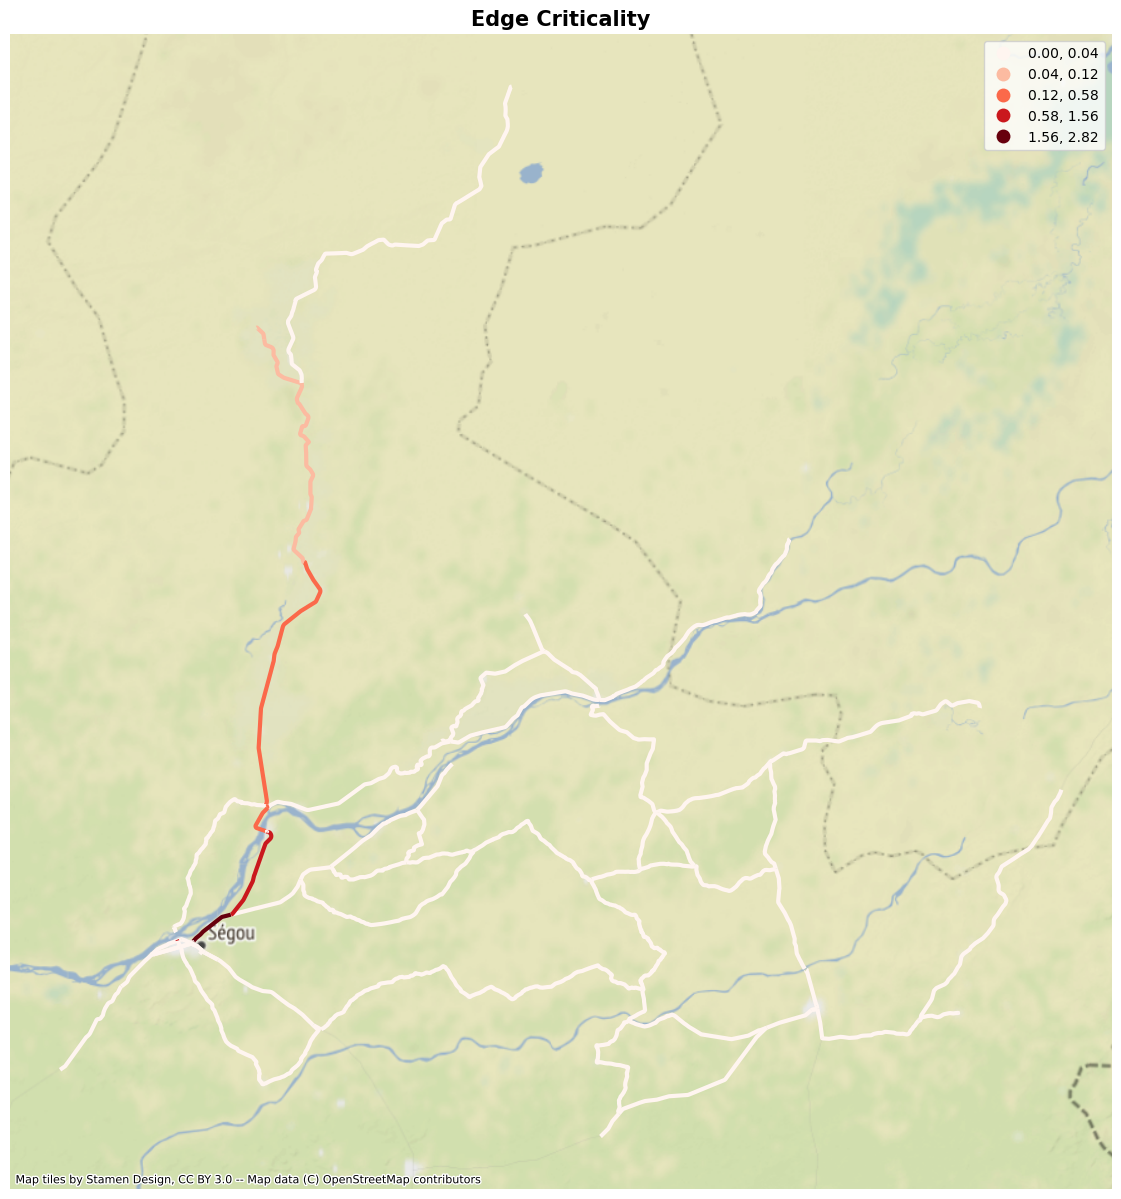

In [84]:
f, ax = plt.subplots(figsize=(15, 15))
b.plot(ax=ax, column='criticality', cmap='Reds', alpha=1, scheme='fisher_jenks', linewidth=3, legend=True)
ax.set_axis_off()
ax.set_title('Edge Criticality', fontsize = 15, fontweight ="bold")
cx.add_basemap(ax, crs=b.crs.to_string())

plt.show()

C:\Users\maaik\miniconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


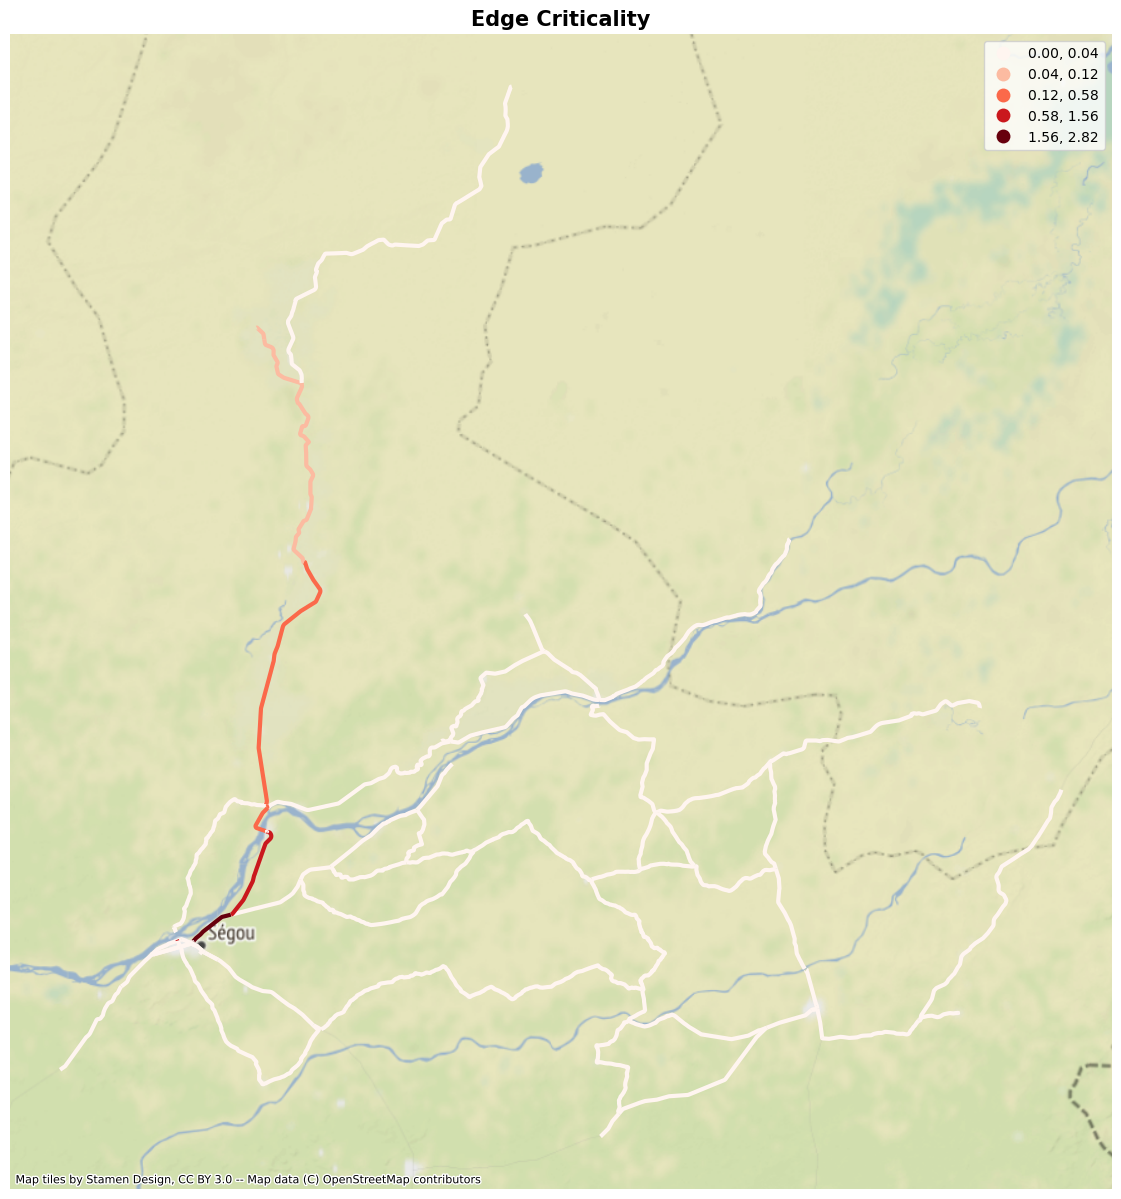

In [85]:
f, ax = plt.subplots(figsize=(15, 15))
b.plot(ax=ax, column='criticality', cmap='Reds', alpha=1, scheme='natural_breaks', linewidth=3, legend=True)
ax.set_axis_off()
ax.set_title('Edge Criticality', fontsize = 15, fontweight ="bold")
cx.add_basemap(ax, crs=b.crs.to_string())

plt.show()

C:\Users\maaik\miniconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


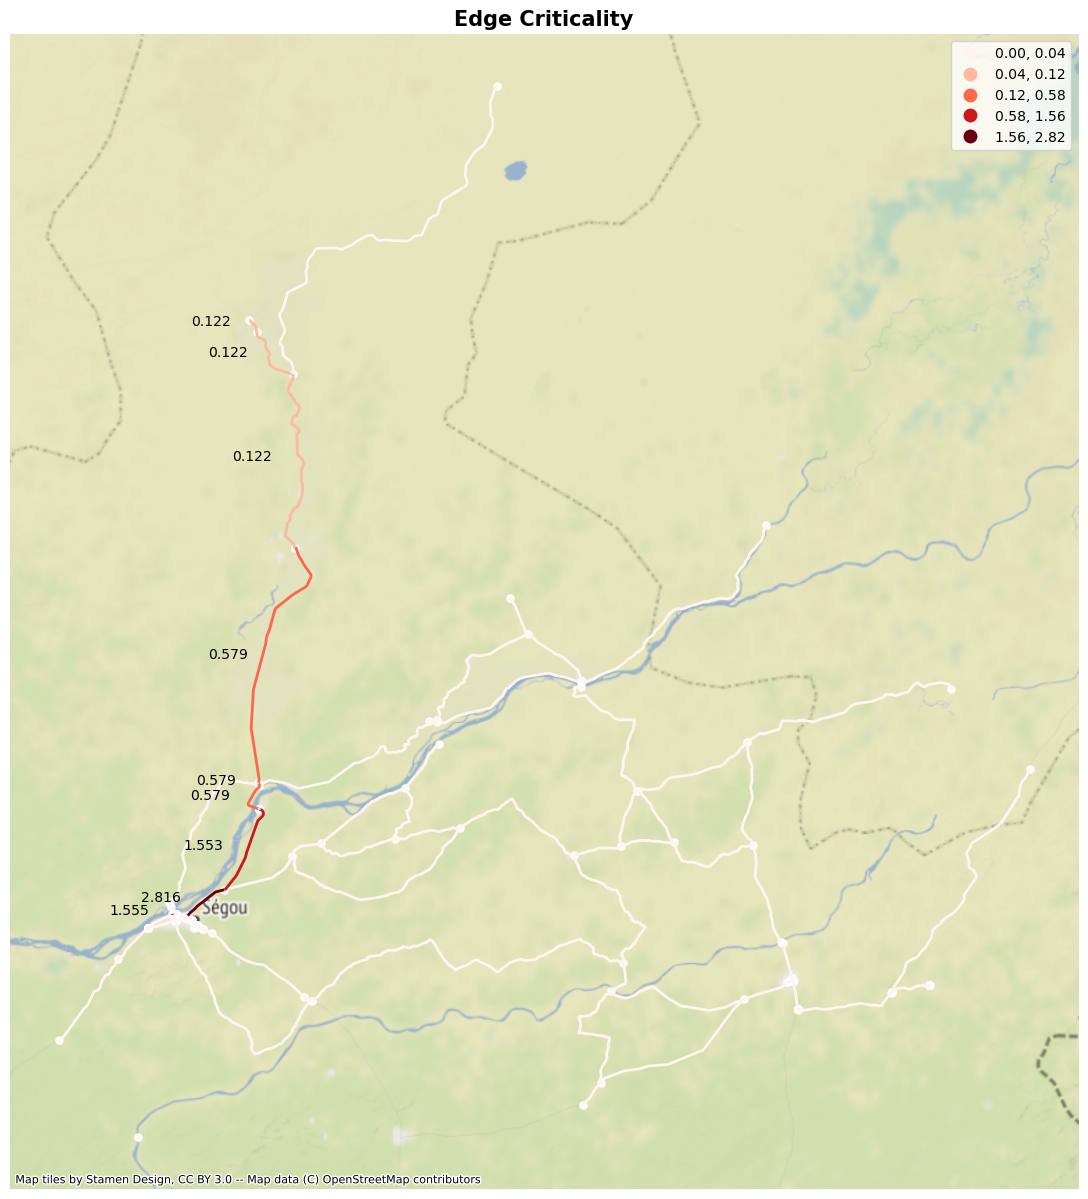

In [86]:
f, ax = plt.subplots(figsize=(15, 15))
b.plot(ax=ax, column='criticality', cmap='Reds', alpha=1, scheme='natural_breaks', linewidth=2, legend=True)
a.plot(ax=ax, c='w', alpha=0.9,  linewidth=0.2)

ax.set_axis_off()
ax.set_title('Edge Criticality', fontsize = 15, fontweight ="bold")
cx.add_basemap(ax, crs=b.crs.to_string())

for _, edge in ox.graph_to_gdfs(graph, nodes=False).fillna('').iterrows():
    c = edge['geometry'].centroid
    text = edge['criticality']
    text = round(text, 3)
    if text <0.04:
        text = 'nothing'
    else:
        text = str(text)
        ax.annotate(text, (c.x-0.14, c.y), c='k')

plt.show()

In [87]:
ox.save_graphml(graph, './results/SegouGraph1207231715.graphml')